In [1]:
import math
from shapely.geometry import shape, Point, LineString, mapping
import numpy as np
import pandas as pd

from collections import OrderedDict
from mpa_sim.services.generate_hex import produce_sites_and_site_areas
from mpa_sim.services.system_simulator import SimulationManager

import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
def space(s, e, n):
    arr = [s]
    i = 1
    r = math.exp((np.log(e/s) / (n-1)))
    print(r)
    while i <= n:
        arr.append(arr[-1]*pow(r, i))
        i += 1
    return arr

In [3]:
def generate_receivers(site_area, parameters, grid):
    receivers = []

    number_of_ue =  500

    if grid == 1:

        geom = shape(site_area[0]['geometry'])
        geom_box = geom.bounds

        minx = geom_box[0]
        miny = geom_box[1]
        maxx = geom_box[2]
        maxy = geom_box[3]

        id_number = 0

        # x_axis = np.array(space(minx, maxx, number_of_ue))
        # y_axis = np.array(space(miny, maxy, number_of_ue))

        x_axis = np.linspace(
            minx, maxx, num=(
                int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
                )
        )
        

        y_axis = np.linspace(
            miny, maxy, num=(
                int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
                )
            )

        xv, yv = np.meshgrid(x_axis, y_axis, sparse=False, indexing='ij')
        
        for i in range(len(x_axis)):
            for j in range(len(y_axis)):
                receiver = Point((xv[i,j], yv[i,j]))
                indoor_outdoor_probability = np.random.rand(1,1)[0][0]
                if geom.contains(receiver):
                    receivers.append({
                        'type': "Feature",
                        'geometry': {
                            "type": "Point",
                            "coordinates": [xv[i,j], yv[i,j]],
                        },
                        'properties': {
                            'ue_id': "id_{}".format(id_number),
                            "misc_losses": parameters['rx_misc_losses'],
                            "gain": parameters['rx_gain'],
                            "losses": parameters['rx_losses'],
                            "ue_height": float(parameters['rx_height']),
                            "indoor": (True if float(indoor_outdoor_probability) < \
                                float(0.5) else False),
                        }
                    })
                    id_number += 1

                else:
                    pass

    else:

        centroid = shape(site_area[0]['geometry']).centroid

        coord = site_area[0]['geometry']['coordinates'][0][0]
        path = LineString([(coord), (centroid)])
        length = int(path.length)
        increment = int(length / 20)

        indoor = parameters['indoor_users_percentage'] / 100

        id_number = 0
        for increment_value in range(1, 20):
            point = path.interpolate(increment * increment_value)
            indoor_outdoor_probability = np.random.rand(1,1)[0][0]
            receivers.append({
                'type': "Feature",
                'geometry': mapping(point),
                'properties': {
                    'ue_id': "id_{}".format(id_number),
                    "misc_losses": parameters['rx_misc_losses'],
                    "gain": parameters['rx_gain'],
                    "losses": parameters['rx_losses'],
                    "ue_height": float(parameters['rx_height']),
                    "indoor": (True if float(indoor_outdoor_probability) < \
                        float(indoor) else False),
                }
            })
            id_number += 1

    return receivers

In [4]:
def obtain_percentile_values(results, transmission_type, parameters, confidence_intervals):
    output = []

    path_loss_values = []
    received_power_values = []
    interference_values = []
    sinr_values = []
    spectral_efficiency_values = []
    estimated_capacity_values = []
    estimated_capacity_values_km2 = []

    for result in results:

        path_loss_values.append(result['path_loss'])

        received_power_values.append(result['received_power'])

        interference_values.append(result['interference'])

        sinr = result['sinr']
        if sinr == None:
            sinr = 0
        else:
            sinr_values.append(sinr)

        spectral_efficiency = result['spectral_efficiency']
        if spectral_efficiency == None:
            spectral_efficiency = 0
        else:
            spectral_efficiency_values.append(spectral_efficiency)

        estimated_capacity = result['capacity_mbps']
        if estimated_capacity == None:
            estimated_capacity = 0
        else:
            estimated_capacity_values.append(estimated_capacity)

        estimated_capacity_km2 = result['capacity_mbps_km2']
        if estimated_capacity_km2 == None:
            estimated_capacity_km2 = 0
        else:
            estimated_capacity_values_km2.append(estimated_capacity_km2)

    for confidence_interval in confidence_intervals:

        output.append({
            'confidence_interval': confidence_interval,
            'tranmission_type': transmission_type,
            'path_loss': np.percentile(
                path_loss_values, confidence_interval #<- low path loss is better
            ),
            'received_power': np.percentile(
                received_power_values, 100 - confidence_interval
            ),
            'interference': np.percentile(
                interference_values, confidence_interval #<- low interference is better
            ),
            'sinr': np.percentile(
                sinr_values, 100 - confidence_interval
            ),
            'spectral_efficiency': np.percentile(
                spectral_efficiency_values, 100 - confidence_interval
            ),
            'capacity_mbps': np.percentile(
                estimated_capacity_values, 100 - confidence_interval
            ),
            'capacity_mbps_km2': np.percentile(
                estimated_capacity_values_km2, 100 - confidence_interval
            )
        })

    return output


def get_modulation(spectral_efficiency, modulation_and_coding_lut):
    """

    Function to get spectral efficiency and modulation and coding parameters and return the modulation type.
    
    Parameters
    ----------
    spectral_efficiency : float
        Efficiency of information transfer in Bps/Hz.
    modulation_and_coding_lut : list of tuples
        A lookup table containing modulation and coding rates,
        spectral efficiencies and SINR estimates.

    Returns
    -------
    modulation : string
        Type of modulation if exist, otherwise None

    """
    for item in modulation_and_coding_lut:
        if item[5] == spectral_efficiency:
            return item[3]
    return None


In [5]:
def run_simulator(parameters, spectrum_portfolio, ant_types,
    site_radii, modulation_and_coding_lut):
    """

    Function to run the simulator and all associated modules.

    """
    unprojected_point = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': (37.3899962, -121.9757812),
            },
        'properties': {
            'site_id': 'Crystal Palace Radio Tower'
            }
        }

    unprojected_crs = 'epsg:4326'
    projected_crs = 'epsg:3857'

    environments =[
        'urban',
        'suburban',
        'rural'
    ]
    
    temp = []

    for environment in environments:
        for ant_type in ant_types:
            site_radii_generator = site_radii[ant_type]
            for site_radius in site_radii_generator[environment]:
#                 print(site_radius)

                if environment == 'urban' and site_radius > 5000:
                    continue
                if environment == 'suburban' and site_radius > 15000:
                    continue

#                 print('--working on {}: {}'.format(environment, site_radius))

                transmitter, interfering_transmitters, site_area, int_site_areas = \
                    produce_sites_and_site_areas(
                        unprojected_point['geometry']['coordinates'],
                        site_radius,
                        unprojected_crs,
                        projected_crs
                        )

                receivers = generate_receivers(site_area, PARAMETERS, 1)

                for frequency, bandwidth, generation, transmission_type in spectrum_portfolio:

#                     print('{}, {}, {}, {}'.format(frequency, bandwidth, generation, transmission_type))

                    MANAGER = SimulationManager(
                        transmitter, interfering_transmitters, ant_type,
                        receivers, site_area, PARAMETERS
                        )

                    results = MANAGER.estimate_link_budget(
                        frequency,
                        bandwidth,
                        generation,
                        ant_type,
                        transmission_type,
                        environment,
                        modulation_and_coding_lut,
                        parameters
                        )
                    # print('results : ', results)
                    
                    df = pd.DataFrame(results)
                    df = df.assign(
                        environment = environment, 
                        site_radius = site_radius, 
                        frequency = frequency, 
                        bandwidth = bandwidth, 
                        generation = generation, 
                        ant_type = ant_type, 
                        transmission_type = transmission_type,
#                         modulation = get_modulation(df['spectral_efficiency'], modulation_and_coding_lut)
                    )
                    df['modulation'] = df['spectral_efficiency'].apply(lambda se: get_modulation(se, MODULATION_AND_CODING_LUT))
                    temp.append(df)
                    
    return(pd.concat(temp, ignore_index = True))


In [6]:
PARAMETERS = {
    'iterations': 20,
    'seed_value1': 1,
    'seed_value2': 2,
    'indoor_users_percentage': 50,
    'los_breakpoint_m': 500,
    'tx_macro_baseline_height': 30,
    'tx_macro_power': 40,
    'tx_macro_gain': 16,
    'tx_macro_losses': 1,
    'tx_micro_baseline_height': 10,
    'tx_micro_power': 24,
    'tx_micro_gain': 5,
    'tx_micro_losses': 1,
    'rx_gain': 4,
    'rx_losses': 4,
    'rx_misc_losses': 4,
    'rx_height': 1.5,
    'building_height': 5,
    'street_width': 20,
    'above_roof': 0,
    'network_load': 50,
    'percentile': 50,
    'sectorization': 3,
    'mnos': 2,
    'asset_lifetime': 10,
    'discount_rate': 3.5,
    'opex_percentage_of_capex': 10,
    'signaling_overhead': 0.18,
    'modulation_compression': True,
    'compression_ratio': {
        'QPSK': 0.06,
        '16QAM': 0.12,
        '64QAM': 0.18,
        '256QAM': 0.25,
    },
}

# bandwidth, freq
SPECTRUM_PORTFOLIO = [
    (3.7, 10, '5G', '1x1'),
]

ANT_TYPE = [
    ('macro'),
    ('micro'),
]

MODULATION_AND_CODING_LUT =[
    # ETSI. 2018. ‘5G; NR; Physical Layer Procedures for Data
    # (3GPP TS 38.214 Version 15.3.0 Release 15)’. Valbonne, France: ETSI.
    # Generation MIMO CQI Index	Modulation	Coding rate
    # Spectral efficiency (bps/Hz) SINR estimate (dB)
    ('5G', '8x8', 1, 'QPSK', 78, 0.30, -6.7),
    ('5G', '8x8', 2, 'QPSK', 193, 2.05, -4.7),
    ('5G', '8x8', 3, 'QPSK', 449, 4.42, -2.3),
    ('5G', '8x8', 4, '16QAM', 378, 6.40, 0.2),
    ('5G', '8x8', 5, '16QAM', 490, 8.00, 2.4),
    ('5G', '8x8', 6, '16QAM', 616, 10.82, 4.3),
    ('5G', '8x8', 7, '64QAM', 466, 12.40, 5.9),
    ('5G', '8x8', 8, '64QAM', 567, 16.00, 8.1),
    ('5G', '8x8', 9, '64QAM', 666, 19.00, 10.3),
    ('5G', '8x8', 10, '64QAM', 772, 22.00, 11.7),
    ('5G', '8x8', 11, '64QAM', 873, 28.00, 14.1),
    ('5G', '8x8', 12, '256QAM', 711, 32.00, 16.3),
    ('5G', '8x8', 13, '256QAM', 797, 38.00, 18.7),
    ('5G', '8x8', 14, '256QAM', 885, 44.00, 21),
    ('5G', '8x8', 15, '256QAM', 948, 50.00, 22.7),
]

unprojected_point = {
    'type': 'Feature',
    'geometry': {
        'type': 'Point',
        'coordinates': (37.3899962, -121.9757812), #Great America Parkway, Santa Clara, CA 95054-1231, United States of America
        },
    'properties': {
        'site_id': 'Crystal Palace Radio Tower'
        }
    }
# 1000- 71, 400- 65
site_radius = 400
unprojected_crs = 'epsg:4326'
projected_crs = 'epsg:3857'
transmitter, interfering_transmitters, site_area, int_site_areas = \
    produce_sites_and_site_areas(
        unprojected_point['geometry']['coordinates'],
        site_radius,
        unprojected_crs,
        projected_crs
        )
interferences_x, interferences_y = [], []
for int_trans in interfering_transmitters:
    interferences_x.append(int_trans['geometry']['coordinates'][0])
    interferences_y.append(int_trans['geometry']['coordinates'][1])
receivers = generate_receivers(site_area, PARAMETERS, 1)  

def generate_site_radii(min, max, increment):
    for n in range(min, max, increment):
        yield n
        
INCREMENT_MA = (400, 30400, 1000) 
INCREMENT_MI = (40, 540, 80)

SITE_RADII = {
    'macro': {
        'urban':
            generate_site_radii(INCREMENT_MA[0],INCREMENT_MA[1],INCREMENT_MA[2]),
        'suburban':
            generate_site_radii(INCREMENT_MA[0],INCREMENT_MA[1],INCREMENT_MA[2]),
        'rural':
            generate_site_radii(INCREMENT_MA[0],INCREMENT_MA[1],INCREMENT_MA[2])
        },
    'micro': {
        'urban':
            generate_site_radii(INCREMENT_MI[0],INCREMENT_MI[1],INCREMENT_MI[2]),
        'suburban':
            generate_site_radii(INCREMENT_MI[0],INCREMENT_MI[1],INCREMENT_MI[2]),
        'rural':
            generate_site_radii(INCREMENT_MI[0],INCREMENT_MI[1],INCREMENT_MI[2])
        },
    }

In [7]:
len(receivers)

65

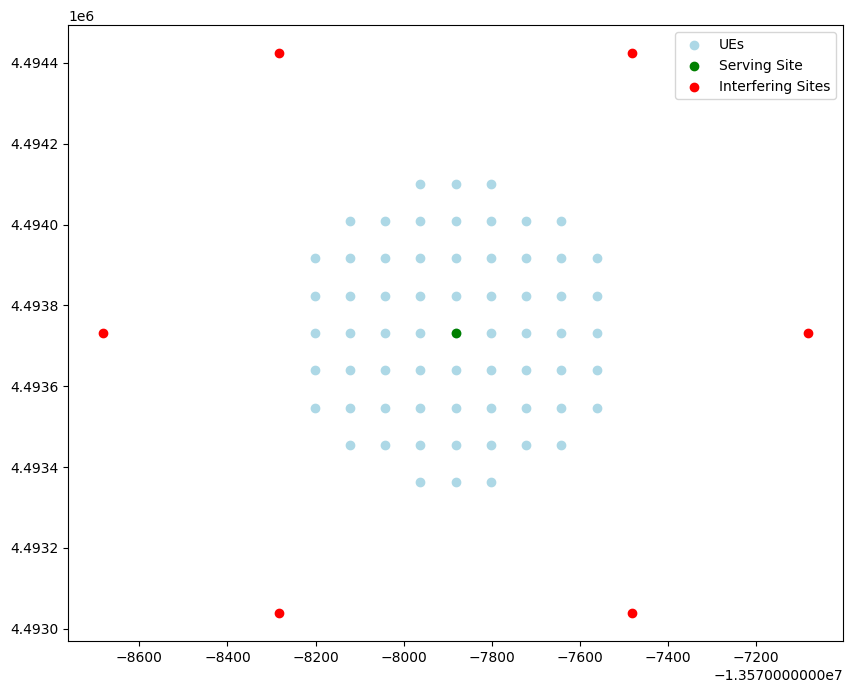

In [8]:
X, Y = [] , []
for r in receivers:
    X.append(r['geometry']['coordinates'][0])
    Y.append(r['geometry']['coordinates'][1])
plt.figure(figsize=(10,8))    
plt.scatter(X,Y, color = 'lightblue', label="UEs")
plt.scatter(transmitter[0]['geometry']['coordinates'][0],transmitter[0]['geometry']['coordinates'][1], color='green', label="Serving Site")
plt.scatter(interferences_x,interferences_y, color = 'red', label="Interfering Sites")
plt.legend()
plt.show()

In [9]:
df = run_simulator(
    PARAMETERS,
    SPECTRUM_PORTFOLIO,
    ANT_TYPE,
    SITE_RADII,
    MODULATION_AND_CODING_LUT
    )


In [10]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 100)
df.head()

,id,path_loss,r_model,type_of_sight,ave_inf_pl,received_power,distance,interference,i_model,network_load,ave_distance,noise,i_plus_n,tranmission_type,sinr,spectral_efficiency,modulation,capacity_mbps,capacity_mbps_km2,receiver_x,receiver_y,fronthaul_capacity_mbps,signaling_overhead_mbps,environment,site_radius,frequency,bandwidth,generation,ant_type,transmission_type
0,id_0,100,etsi_tr_138_901,los,142.333333,-49.0,369.504172,-84.00000,etsi_tr_138_901,50,843.558383,-102.477229,-84.00000,1x1,35.0,50.0,256QAM,500.0,902.109796,-1.357820e+07,4.493547e+06,125.0,90.0,urban,400,3.7,10,5G,macro,1x1
1,id_1,96,etsi_tr_138_901,los,134.000000,-45.0,333.066560,-48.30103,etsi_tr_138_901,50,835.078261,-102.477229,-48.30103,1x1,3.3,8.0,16QAM,80.0,144.337567,-1.357820e+07,4.493639e+06,9.6,14.4,urban,400,3.7,10,5G,macro,1x1
2,id_2,96,etsi_tr_138_901,los,134.000000,-45.0,320.000000,-48.30103,etsi_tr_138_901,50,832.207837,-102.477229,-48.30103,1x1,3.3,8.0,16QAM,80.0,144.337567,-1.357820e+07,4.493731e+06,9.6,14.4,urban,400,3.7,10,5G,macro,1x1
3,id_3,99,etsi_tr_138_901,los,137.000000,-48.0,333.066560,-51.30103,etsi_tr_138_901,50,835.078261,-102.477229,-51.30103,1x1,3.3,8.0,16QAM,80.0,144.337567,-1.357820e+07,4.493824e+06,9.6,14.4,urban,400,3.7,10,5G,macro,1x1
4,id_4,97,etsi_tr_138_901,los,139.333333,-46.0,369.504172,-81.00000,etsi_tr_138_901,50,843.558383,-102.477229,-81.00000,1x1,35.0,50.0,256QAM,500.0,902.109796,-1.357820e+07,4.493916e+06,125.0,90.0,urban,400,3.7,10,5G,macro,1x1


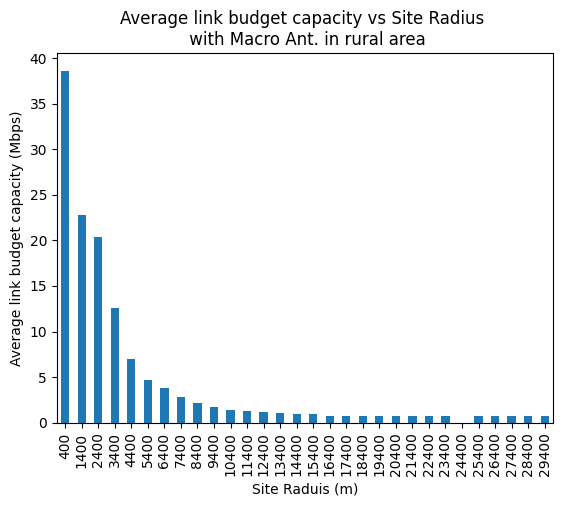

In [11]:
df_plot = df[(df["environment"]=="rural") & (df["ant_type"]=="macro")].groupby("site_radius").mean()
p = df_plot["spectral_efficiency"].plot(
    kind="bar",
    title = "Average link budget capacity vs Site Radius \n with Macro Ant. in rural area",
    ylabel = "Average link budget capacity (Mbps)",
    xlabel = "Site Raduis (m)"
    )

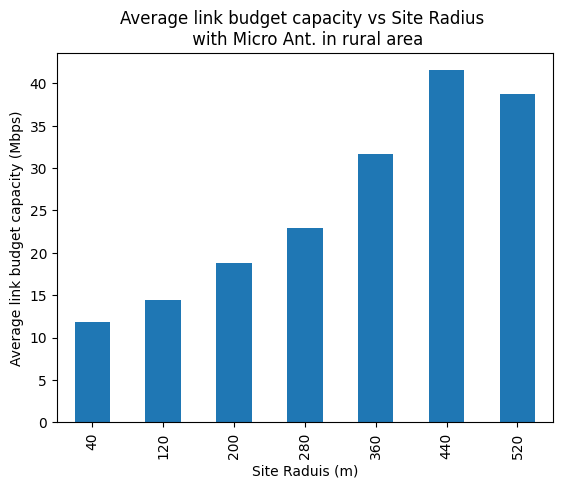

In [12]:
df_plot = df[(df["environment"]=="rural") & (df["ant_type"]=="micro")].groupby("site_radius").mean()
p = df_plot["spectral_efficiency"].plot(
    kind="bar",
    title = "Average link budget capacity vs Site Radius \n with Micro Ant. in rural area",
    ylabel = "Average link budget capacity (Mbps)",
    xlabel = "Site Raduis (m)"
    )

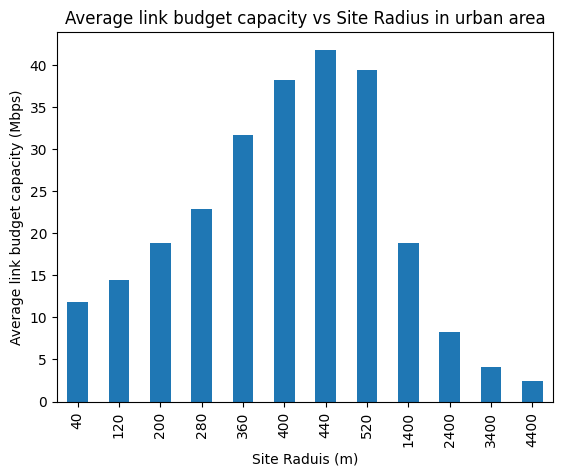

In [13]:
df_plot = df[df["environment"]=="urban"].groupby("site_radius").mean()
p = df_plot["spectral_efficiency"].plot(
    kind="bar",
    title = "Average link budget capacity vs Site Radius in urban area",
    ylabel = "Average link budget capacity (Mbps)",
    xlabel = "Site Raduis (m)"
    )

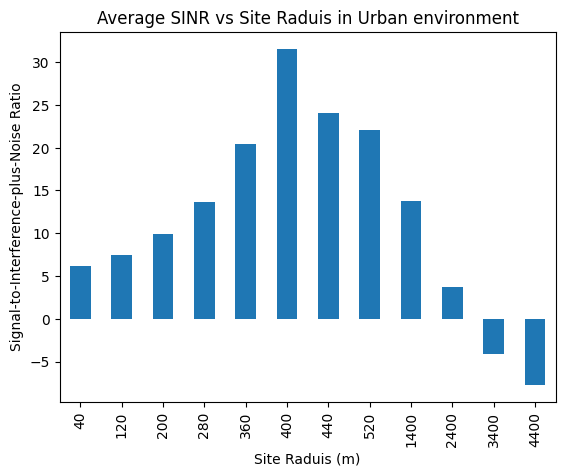

In [14]:
df_plot = df[df["environment"]=="urban"].groupby("site_radius").mean()
p = df_plot["sinr"].plot(
    kind= "bar",
    title = "Average SINR vs Site Raduis in Urban environment",
    ylabel = "Signal-to-Interference-plus-Noise Ratio",
    xlabel = "Site Raduis (m)"
    )

In [15]:
df[df["environment"]=="urban"].groupby("site_radius").mean()

,path_loss,ave_inf_pl,received_power,distance,interference,network_load,ave_distance,noise,i_plus_n,sinr,spectral_efficiency,capacity_mbps,capacity_mbps_km2,receiver_x,receiver_y,fronthaul_capacity_mbps,signaling_overhead_mbps,frequency,bandwidth
site_radius,,,,,,,,,,,,,,,,,,,
40,76.861538,86.169231,-52.861538,27.783227,-59.092194,50.0,82.414583,-102.477229,-59.092194,6.231692,11.824000,118.240000,21333.092447,-1.357824e+07,4.493620e+06,18.830031,21.283200,3.7,10.0
120,85.569231,97.676923,-61.569231,78.405401,-69.063917,50.0,247.243749,-102.477229,-69.063917,7.495692,14.439385,144.393846,2894.646734,-1.357840e+07,4.493645e+06,25.583877,25.990892,3.7,10.0
200,90.153846,110.610256,-66.153846,130.470540,-76.054524,50.0,412.072916,-102.477229,-76.054524,9.900923,18.840000,188.400000,1359.659884,-1.357848e+07,4.493669e+06,36.326769,33.912000,3.7,10.0
280,93.538462,126.753846,-69.538462,182.535679,-83.613361,50.0,576.902082,-102.477229,-83.154298,13.616000,22.898462,228.984615,843.139855,-1.357800e+07,4.493694e+06,49.478769,41.217231,3.7,10.0
360,96.923077,135.497436,-72.923077,234.600818,-97.351913,50.0,741.731248,-102.477229,-93.378081,20.456000,31.614154,316.141538,704.183651,-1.357792e+07,4.493719e+06,73.484677,56.905477,3.7,10.0
400,94.507692,139.312821,-43.507692,260.633388,-75.062302,50.0,824.145831,-102.477229,-75.062302,31.554769,38.172308,381.723077,688.712254,-1.357788e+07,4.493731e+06,92.806769,68.710154,3.7,10.0
440,100.463768,140.275362,-76.463768,297.041973,-108.505099,50.0,908.676217,-102.477229,-100.485785,24.024348,41.797101,417.971014,623.232639,-1.357784e+07,4.493744e+06,103.889855,75.234783,3.7,10.0
520,104.405797,143.236715,-80.405797,350.996903,-113.590981,50.0,1073.890074,-102.477229,-102.477229,22.074203,39.371014,393.710145,420.319264,-1.357880e+07,4.493768e+06,96.706667,70.867826,3.7,10.0
1400,139.315068,162.114155,-88.315068,969.969703,-104.725582,50.0,2896.053806,-102.477229,-102.030404,13.716986,18.889589,188.895890,27.821197,-1.357688e+07,4.494041e+06,39.259288,34.001260,3.7,10.0


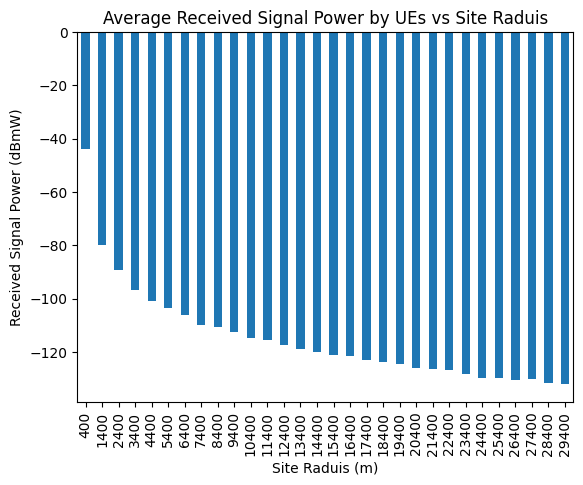

In [16]:
df_plot = df[(df["environment"]=="rural") & (df["ant_type"]=="macro")].groupby("site_radius").mean()
p = df_plot["received_power"].plot(
    kind= "bar",
    title = "Average Received Signal Power by UEs vs Site Raduis",
    ylabel = "Received Signal Power (dBmW)",
    xlabel = "Site Raduis (m)"
    )

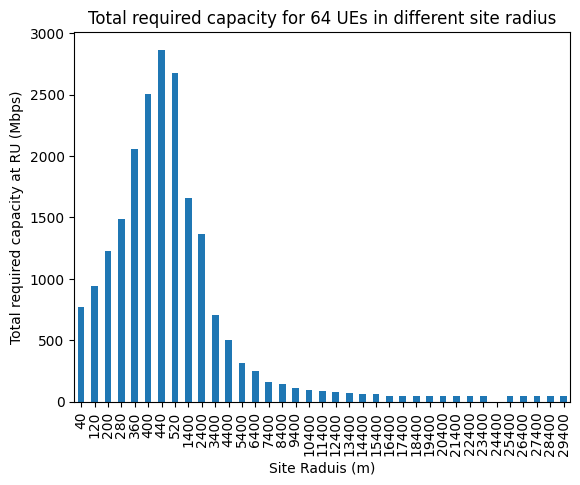

In [17]:
df_plot = df[df["environment"]=="rural"].groupby("site_radius").sum()
p = df_plot["spectral_efficiency"].plot(
    kind="bar",
    title = "Total required capacity for 64 UEs in different site radius",
    ylabel = "Total required capacity at RU (Mbps)",
    xlabel = "Site Raduis (m)"
    )

In [18]:
df[:2]

,id,path_loss,r_model,type_of_sight,ave_inf_pl,received_power,distance,interference,i_model,network_load,ave_distance,noise,i_plus_n,tranmission_type,sinr,spectral_efficiency,modulation,capacity_mbps,capacity_mbps_km2,receiver_x,receiver_y,fronthaul_capacity_mbps,signaling_overhead_mbps,environment,site_radius,frequency,bandwidth,generation,ant_type,transmission_type
0,id_0,100,etsi_tr_138_901,los,142.333333,-49.0,369.504172,-84.00000,etsi_tr_138_901,50,843.558383,-102.477229,-84.00000,1x1,35.0,50.0,256QAM,500.0,902.109796,-1.357820e+07,4.493547e+06,125.0,90.0,urban,400,3.7,10,5G,macro,1x1
1,id_1,96,etsi_tr_138_901,los,134.000000,-45.0,333.066560,-48.30103,etsi_tr_138_901,50,835.078261,-102.477229,-48.30103,1x1,3.3,8.0,16QAM,80.0,144.337567,-1.357820e+07,4.493639e+06,9.6,14.4,urban,400,3.7,10,5G,macro,1x1


In [19]:
df.to_csv("simulation_results.csv",index=False)

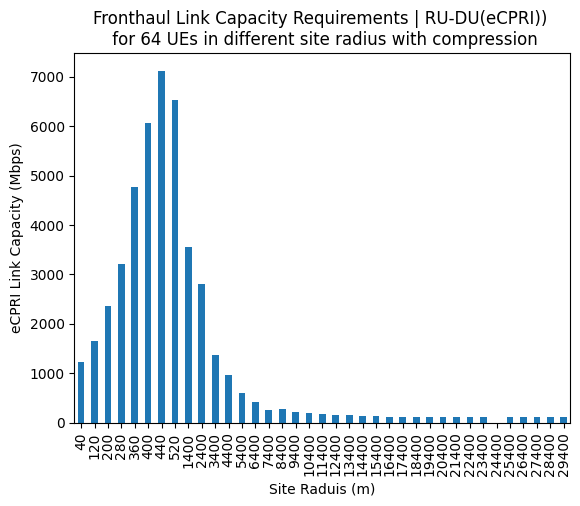

In [20]:
df_plot = df[df["environment"]=="rural"].groupby("site_radius").sum()
p = df_plot["fronthaul_capacity_mbps"].plot(
    kind="bar",
    title = "Fronthaul Link Capacity Requirements | RU-DU(eCPRI)) \n for 64 UEs in different site radius with compression",
    ylabel = "eCPRI Link Capacity (Mbps)",
    xlabel = "Site Raduis (m)"
    )

In [21]:
10**-6

1e-06